In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
%matplotlib inline

from datetime import datetime, timedelta
import seaborn as sns

from global_config import config

data_dir      = config.get_property('covid_fb')
geo_dir       = config.get_property('geo_dir')
results_dir   = config.get_property('results_dir')


In [3]:
# Loads the rt
df_rt = pd.read_csv( os.path.join(results_dir, 'rt_merged_all.csv'),  parse_dates = ['date'])
df_rt['poly_id'] = df_rt.region.apply(lambda s: s.lower().replace('í','i').replace('ó','o').replace('á','a').replace('é','e').replace('ñ','n').replace(' ','_'))
df_rt.sample(10)

Unnamed: 0       date    median      mean  lower_90  lower_50  lower_20  \
58            58 2020-05-21  1.090565  1.081465  0.978823  1.053889  1.078072   
5044         170 2020-09-06  0.965622  0.967912  0.918424  0.946454  0.958117   
2668         214 2020-10-24  1.006461  1.006288  0.928092  0.979017  0.997229   
5756         264 2020-12-15  1.078069  1.078677  1.038086  1.060798  1.071201   
2095         261 2020-11-28  1.081860  1.081637  1.025085  1.060343  1.073866   
2307         163 2020-08-22  0.880916  0.880119  0.837394  0.864664  0.874639   
2883         131 2020-08-06  0.969087  0.969604  0.917380  0.950008  0.962653   
4541         285 2020-12-23  1.085263  1.086564  1.028938  1.064407  1.077445   
5761         269 2020-12-20  1.073254  1.074174  1.033175  1.055789  1.066931   
1299          84 2020-06-07  1.209639  1.209823  1.166457  1.192474  1.202909   

      upper_20  upper_50  upper_90          region  region_id         poly_id  
58    1.101706  1.119043  1.153492  Antonio Nariño         15  antonio_narino  
5044  0.973404  0.988043  1.024750      Tunjuelito          6      tunjuelito  
2668  1.017131  1.032228  1.078133   La Candelaria         17   la_candelaria  
5756  1.084524  1.095077  1.122971            Usme          5            usme  
2095  1.089864  1.103891  1.135661        Fontibón          9        fontibon  
2307  0.886448  0.896449  0.918870         Kennedy          8         kennedy  
2883  0.975778  0.987941  1.022647    Los Mártires         14    los_martires  
4541  1.094130  1.109118  1.145766            Suba         11            suba  
5761  1.079718  1.091383  1.118028            Usme          5            usme  
1299  1.216198  1.227180  1.254624  Ciudad Bolívar         19  ciudad_bolivar

In [4]:
df_movement = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb','movement.csv'), parse_dates = ['date_time'])



In [5]:
def read_geo_df(path_to_geodf):
    df_geo = pd.read_csv(path_to_geodf)
    df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
    df_geo = gpd.GeoDataFrame(df_geo, geometry='geometry')
    return df_geo

In [6]:
from shapely.geometry import Point, LineString
from shapely.ops import cascaded_union

from datetime import timedelta
import contextily as ctx

import geopandas as gpd
from shapely import wkt

movement_manz_df = pd.read_csv(  os.path.join(data_dir, 'agglomerated', 'geometry (sectores)', 'movement.csv'), parse_dates = ['date_time'])
sec_poly_df      = read_geo_df( os.path.join(data_dir, 'agglomerated', 'geometry (sectores)', 'polygons.csv' )  )

loc_poly_df      = read_geo_df( os.path.join(data_dir, 'agglomerated', 'geometry', 'polygons.csv')  )

sec_poly_df      = sec_poly_df[["poly_id", "poly_name", "attr_population",	"attr_area", "geometry"]]
loc_poly_df      = loc_poly_df[["poly_id", "poly_name", "geometry"]]


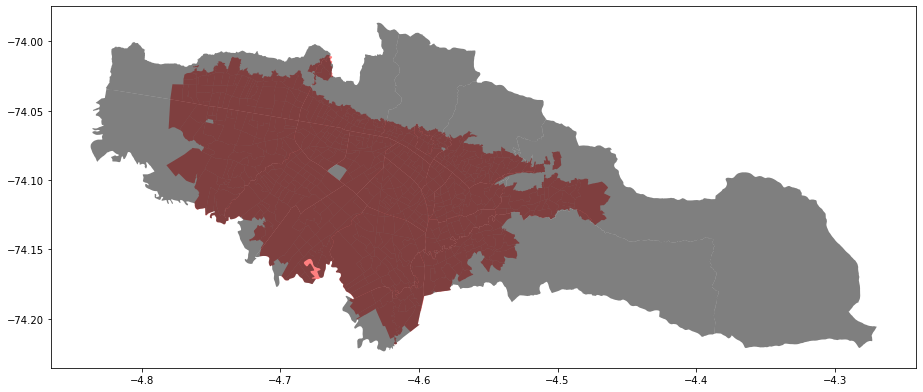

In [7]:
from matplotlib import transforms
fig, ax = plt.subplots(1, 1, figsize=(15.5, 15.2))

base = ax.figure.gca().transData
rot = transforms.Affine2D().rotate_deg(90)


sec_poly_df.plot(ax=ax, alpha=0.5, color='r', transform= rot + base)
loc_poly_df.plot(ax=ax, alpha=0.5, color='k', transform= rot + base)
plt.show()

In [19]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}
                            

# read and rename localities
df_movement_localities = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df_movement_localities["start_poly_id"] = df_movement_localities.start_poly_id.apply(lambda s: ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
df_movement_localities["end_poly_id"]   = df_movement_localities.end_poly_id.apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
df_movement_localities = df_movement_localities.replace( dict_correct )

# Creates type
df_movement_localities["movement_type"] = "External"
df_movement_localities.loc[df.start_poly_id == df.end_poly_id, "movement_type"] = "Internal"

# Consolidates dataframe
d1 = df_movement_localities.loc[df_movement_localities.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

df_movement_localities 

date_time   start_poly_id     end_poly_id  movement movement_type
0     2020-04-12  Barrios Unidos  Barrios Unidos     28117      Internal
1     2020-04-12  Barrios Unidos            Bosa       144      External
2     2020-04-12  Barrios Unidos       Chapinero       133      External
3     2020-04-12  Barrios Unidos  Ciudad Bolívar        47      External
4     2020-04-12  Barrios Unidos        Engativá       488      External
...          ...             ...             ...       ...           ...
68225 2020-12-22            Usme        Santa Fe       451      External
68226 2020-12-22            Usme            Suba        15      External
68227 2020-12-22            Usme     Teusaquillo        77      External
68228 2020-12-22            Usme      Tunjuelito       170      External
68229 2020-12-22            Usme            Usme     16146      Internal

[68230 rows x 5 columns]

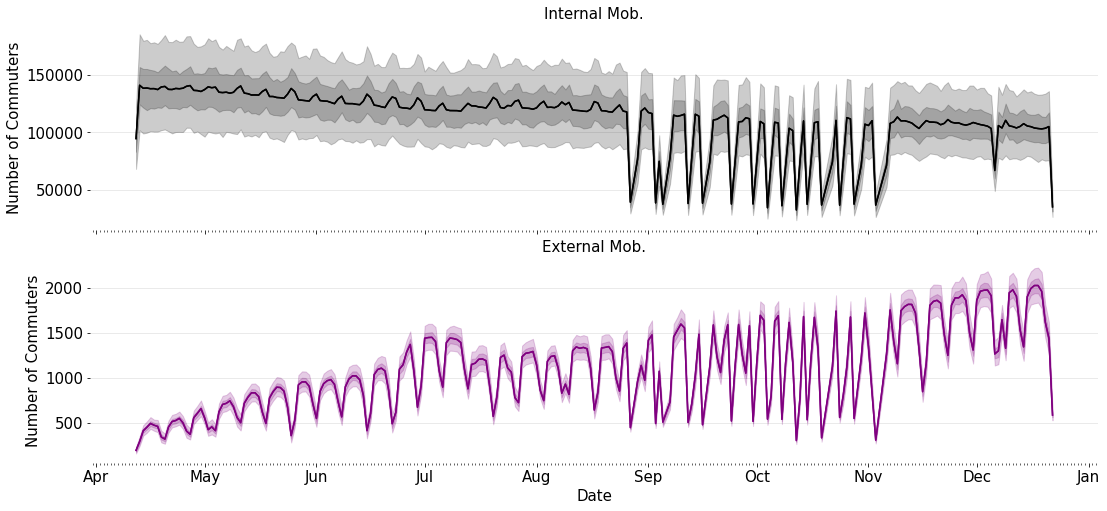

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15.5, 7.2), sharex=True)
sns.lineplot(ax=axes[0], data=df_movement_localities[df_movement_localities.movement_type=='Internal'], x='date_time', y='movement', 
                color='k', err_style='band', ci=90)#, label='Internal')
sns.lineplot(ax=axes[1], data=df_movement_localities[df_movement_localities.movement_type=='External'], x='date_time', y='movement', 
                color='purple', err_style='band', ci=90)#, ,label='External')


sns.lineplot(ax=axes[0], data=df_movement_localities[df_movement_localities.movement_type=='Internal'], x='date_time', y='movement', 
                color='k', err_style='band', ci=50)#, label='Internal')
sns.lineplot(ax=axes[1], data=df_movement_localities[df_movement_localities.movement_type=='External'], x='date_time', y='movement', 
                color='purple', err_style='band', ci=50)#, ,label='External')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.tick_params(axis='both', labelsize=15)

axes[1].set_xlabel('Date', fontsize=15)

axes[0].set_title('Internal Mob.', fontsize=15)
axes[1].set_title('External Mob.', fontsize=15)

axes[0].set_ylabel('Number of Commuters', fontsize=15)
axes[1].set_ylabel('Number of Commuters', fontsize=15)
plt.tight_layout()

path_to_save = '/Users/chaosdonkey06/Dropbox/BIOMAC/bogota_rotating_lockdowns'
path_to_save_fig = os.path.join(path_to_save, 'figures','internal_external_mob.png' )
fig.savefig(path_to_save_fig, dpi=300,  bbox_inches='tight', transparent=True)



In [21]:
# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code":"A",
                  "start_date" : pd.to_datetime("2020-07-13"), 
                  "end_date"   : pd.to_datetime("2020-07-23"), 
                  "places":["chapinero", 
                            "los_martires", 
                            "san_cristobal", 
                            "tunjuelito", 
                            "rafel_uribe_uribe", 
                            "ciudad_bolivar", 
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code":"B",
                  "start_date" : pd.to_datetime("2020-07-23"), 
                  "end_date"   : pd.to_datetime("2020-08-06"), 
                  "places":["bosa", 
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code":"C",
                  "start_date" : pd.to_datetime("2020-07-31"), 
                  "end_date"   : pd.to_datetime("2020-08-14"), 
                  "places":["suba", 
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code":"D",
                  "start_date" : pd.to_datetime("2020-08-16"), 
                  "end_date"   : pd.to_datetime("2020-08-27"), 
                  "places":["usaquen", 
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})

In [30]:

df = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df.start_poly_id = df.start_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))
df.end_poly_id = df.end_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))

# Creates type
df["movement_type"] = "External"
df.loc[df.start_poly_id == df.end_poly_id,"movement_type"] = "Internal"
df.sample(10)


# Consolidates dataframe
d1 = df.loc[df.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

d2 = df.loc[df.movement_type == "External",['date_time','end_poly_id', 'movement','movement_type']]
d2.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

d3 = df.loc[df.movement_type == "Internal",['date_time','end_poly_id', 'movement','movement_type']]
d3.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

df_movement = pd.concat((d1,d2,d3), ignore_index = True)
df_movement_all = df_movement.copy()
df_movement = df_movement.groupby(['date_time','poly_id','movement_type']).sum().reset_index()


In [31]:
df_movement_all

date_time         poly_id  movement movement_type
0      2020-04-12  barrios_unidos       144      External
1      2020-04-12  barrios_unidos       133      External
2      2020-04-12  barrios_unidos        47      External
3      2020-04-12  barrios_unidos       488      External
4      2020-04-12  barrios_unidos       172      External
...           ...             ...       ...           ...
132256 2020-12-22            suba     79991      Internal
132257 2020-12-22     teusaquillo     13097      Internal
132258 2020-12-22      tunjuelito     15514      Internal
132259 2020-12-22         usaquen     44766      Internal
132260 2020-12-22            usme     16146      Internal

[132261 rows x 4 columns]

In [39]:
lock_info

{'code': 'D',
 'start_date': Timestamp('2020-08-16 00:00:00'),
 'end_date': Timestamp('2020-08-27 00:00:00'),
 'places': ['usaquen',
  'chapinero',
  'santa_fe',
  'candelaria',
  'teusaquillo',
  'puente_aranda',
  'antonio_narino']}

In [40]:
df_movement['lockdown_type'] = 'None'

# prelockdown period 
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end   = pd.to_datetime("2020-07-12")

lockdown_start     = pd.to_datetime("2020-07-13") 
lockdown_end       = pd.to_datetime("2020-08-27")

# Assigns moments
df_movement.loc[(df_movement.date_time <= pre_lockdown_end) 
            & (df_movement.date_time >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"

df_movement.loc[(df_movement.date_time <= lockdown_end) 
            & (df_movement.date_time >= lockdown_start),'lockdown_type'] = "lockdown1"

df_movement["lockdown_group"] = 'None'

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    df_movement.loc[(df_movement.date_time <= g_lockdown_end) 
                    & (df_movement.date_time >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]

df_movement["lockdown_group"] = df_movement["lockdown_group"].map(lambda x: x.split('-')[-1])
df_movement.loc[ (df_movement.date_time <= g_lockdown_end) & (df_movement.date_time >= g_lockdown_start)].head(10)

date_time         poly_id movement_type  movement lockdown_type  \
4284 2020-08-16  barrios_unidos      External     22808     lockdown1   
4285 2020-08-16  barrios_unidos      Internal     37263     lockdown1   
4286 2020-08-16            bosa      External     52082     lockdown1   
4287 2020-08-16            bosa      Internal    230879     lockdown1   
4288 2020-08-16       chapinero      External     28816     lockdown1   
4289 2020-08-16       chapinero      Internal     46532     lockdown1   
4290 2020-08-16  ciudad_bolivar      External     25857     lockdown1   
4291 2020-08-16  ciudad_bolivar      Internal    110060     lockdown1   
4292 2020-08-16        engativa      External     55358     lockdown1   
4293 2020-08-16        engativa      Internal    237038     lockdown1   

     lockdown_group  
4284              D  
4285              D  
4286              D  
4287              D  
4288              D  
4289              D  
4290              D  
4291              D  
4292              D  
4293              D

Col1      Col2  X
0 -0.039952 -0.143531  A
1 -0.374165 -2.587908  A
2  2.015985  0.113796  A
3 -0.674274  0.020586  A
4 -1.219291 -0.516025  A
5  0.722131  0.218786  B
6 -0.237616  1.293340  B
7 -0.381252  1.168366  B
8  0.958684  0.730236  B
9 -1.803565  2.305991  B

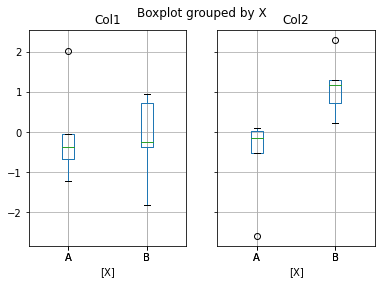

In [43]:
import numpy as np

df = pd.DataFrame(np.random.randn(10, 2),
                   columns=['Col1', 'Col2'])
df['X'] = pd.Series(['A', 'A', 'A', 'A', 'A',
                      'B', 'B', 'B', 'B', 'B'])
boxplot = df.boxplot(by='X')
df

In [45]:
df_movement.head(3)

date_time         poly_id movement_type  movement lockdown_type  \
0 2020-04-12  barrios_unidos      External      2265          None   
1 2020-04-12  barrios_unidos      Internal     28117          None   
2 2020-04-12            bosa      External      6562          None   

  lockdown_group  
0           None  
1           None  
2           None

In [49]:
mov_ext_int_df = pd.pivot_table(df_movement, values='movement', index=['date_time', 'poly_id', 'lockdown_type', 'lockdown_group'], columns=['movement_type']).fillna(0).reset_index().rename(columns={'External': 'mov_ext', 'Internal': 'mov_int'})

mov_ext_int_df = mov_ext_int_df[['date_time', 'poly_id', 'lockdown_type', 'lockdown_group', 'mov_ext', 'mov_int']]
mov_ext_int_df

movement_type  date_time         poly_id lockdown_type lockdown_group  \
0             2020-04-12  barrios_unidos          None           None   
1             2020-04-12            bosa          None           None   
2             2020-04-12       chapinero          None           None   
3             2020-04-12  ciudad_bolivar          None           None   
4             2020-04-12        engativa          None           None   
...                  ...             ...           ...            ...   
4194          2020-12-22            suba          None           None   
4195          2020-12-22     teusaquillo          None           None   
4196          2020-12-22      tunjuelito          None           None   
4197          2020-12-22         usaquen          None           None   
4198          2020-12-22            usme          None           None   

movement_type  mov_ext  mov_int  
0                 2265    28117  
1                 6562   184756  
2                 3310    34619  
3                 3145    89361  
4                 5191   185568  
...                ...      ...  
4194             26310    79991  
4195             12076    13097  
4196              8893    15514  
4197             18440    44766  
4198              4412    16146  

[4199 rows x 6 columns]

In [51]:
pre_lockdown_df = mov_ext_int_df[ mov_ext_int_df["lockdown_type"] == 'pre-lockdown1' ]
pre_lockdown_df

movement_type  date_time         poly_id  lockdown_type lockdown_group  \
1173          2020-06-20  barrios_unidos  pre-lockdown1           None   
1174          2020-06-20            bosa  pre-lockdown1           None   
1175          2020-06-20       chapinero  pre-lockdown1           None   
1176          2020-06-20  ciudad_bolivar  pre-lockdown1           None   
1177          2020-06-20        engativa  pre-lockdown1           None   
...                  ...             ...            ...            ...   
1559          2020-07-12            suba  pre-lockdown1           None   
1560          2020-07-12     teusaquillo  pre-lockdown1           None   
1561          2020-07-12      tunjuelito  pre-lockdown1           None   
1562          2020-07-12         usaquen  pre-lockdown1           None   
1563          2020-07-12            usme  pre-lockdown1           None   

movement_type  mov_ext  mov_int  
1173             24855    41514  
1174             45212   222058  
1175             35641    53304  
1176             17922   103511  
1177             43400   241511  
...                ...      ...  
1559             49467   295510  
1560             17288    33158  
1561             21908    62185  
1562             29540   140885  
1563             11804    66745  

[391 rows x 6 columns]

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = boxplot(


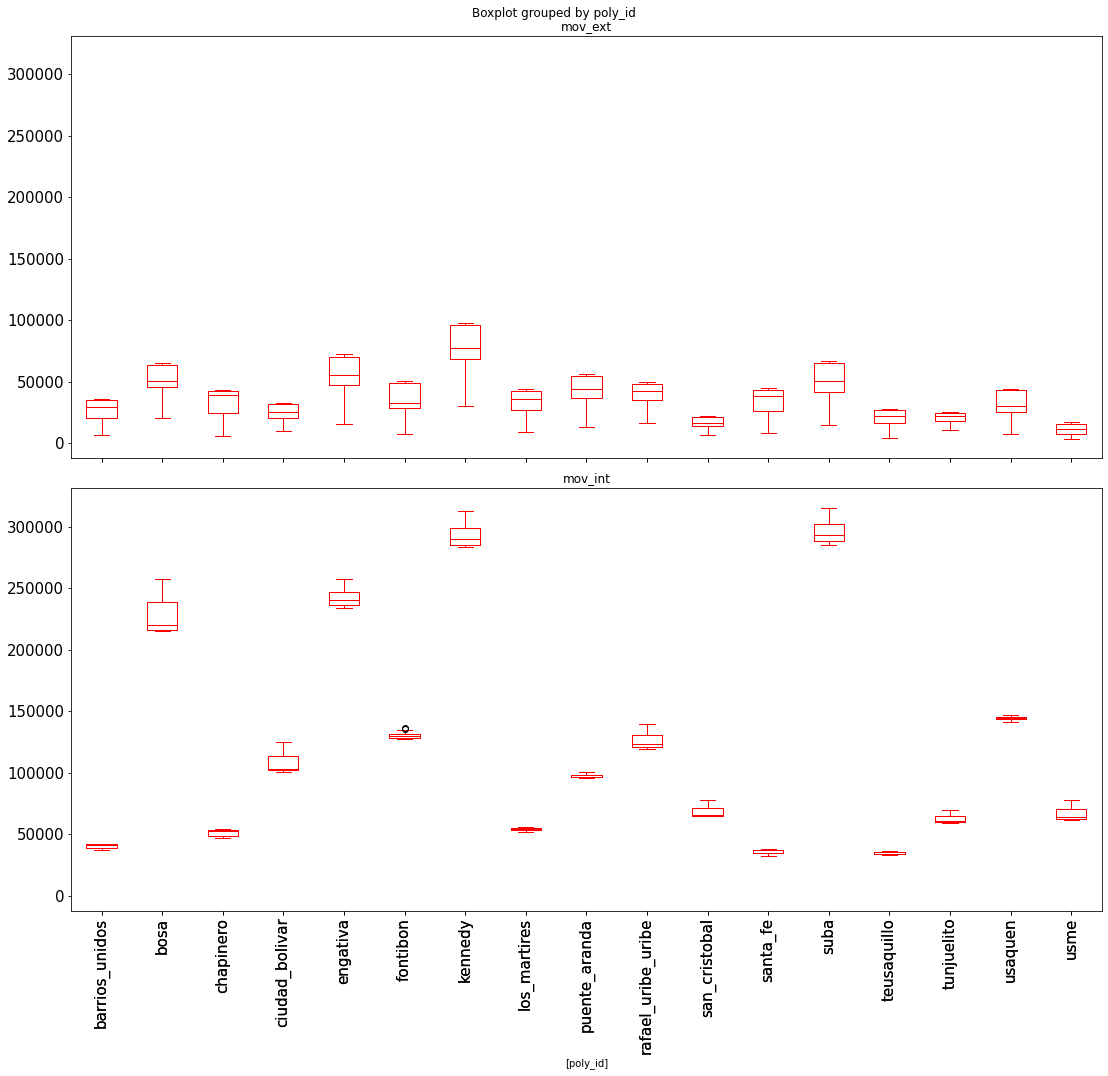

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15.5, 15.2), sharey=False)
boxplot = pre_lockdown_df[['poly_id', 'mov_ext', 'mov_int']].boxplot(ax=ax, by='poly_id', grid=False, rot=90, fontsize=15, color='red', layout=(2, 1))


ax.set_title('Pre-lockdown Movement', )
plt.tight_layout()


In [37]:

def box_plot_movement_locality(df_locality, date_init, date_end, mov_type=['External', 'Internal'], col='movement', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))
    df_locality = df_locality.loc[ (df_locality.date_time <= date_end) & (df_locality.date_time >= date_init)]

    ax.

date_time         poly_id movement_type  movement lockdown_type  \
0    2020-04-12  barrios_unidos      External      2265          None   
1    2020-04-12  barrios_unidos      Internal     28117          None   
2    2020-04-12            bosa      External      6562          None   
3    2020-04-12            bosa      Internal    184756          None   
4    2020-04-12       chapinero      External      3310          None   
...         ...             ...           ...       ...           ...   
8393 2020-12-22      tunjuelito      Internal     15514          None   
8394 2020-12-22         usaquen      External     18440          None   
8395 2020-12-22         usaquen      Internal     44766          None   
8396 2020-12-22            usme      External      4412          None   
8397 2020-12-22            usme      Internal     16146          None   

     lockdown_group  
0              None  
1              None  
2              None  
3              None  
4              None  
...             ...  
8393           None  
8394           None  
8395           None  
8396           None  
8397           None  

[8398 rows x 6 columns]

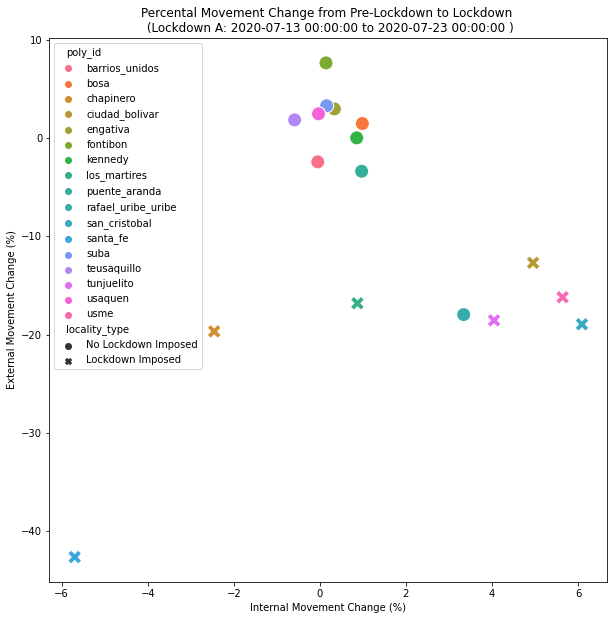

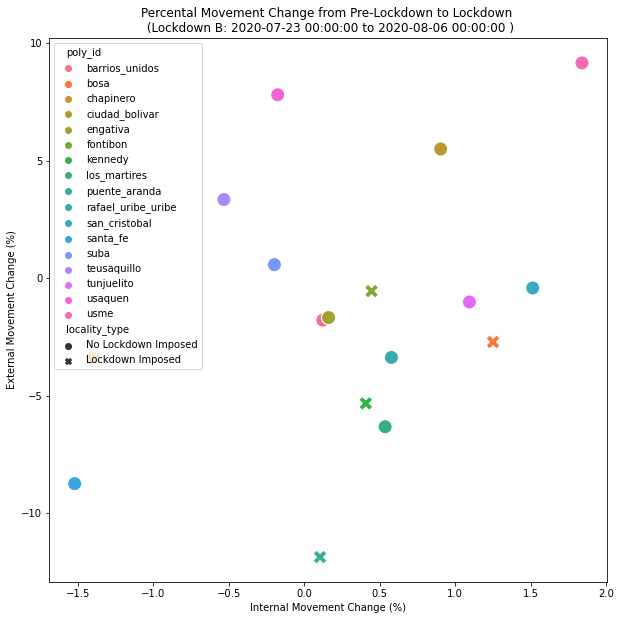

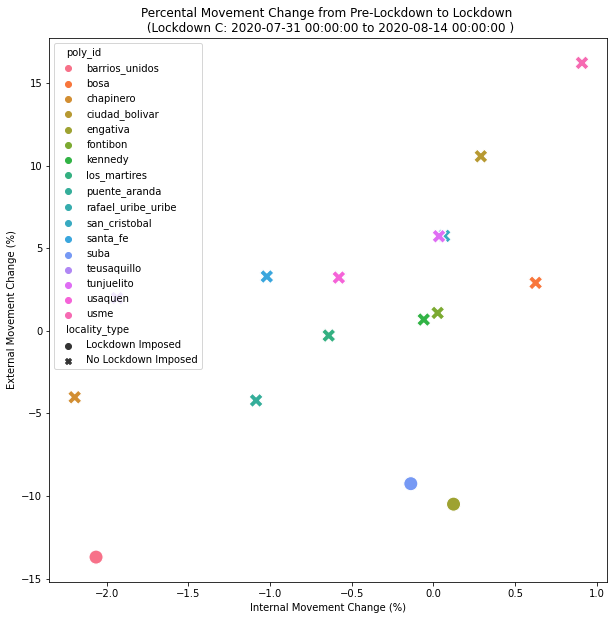

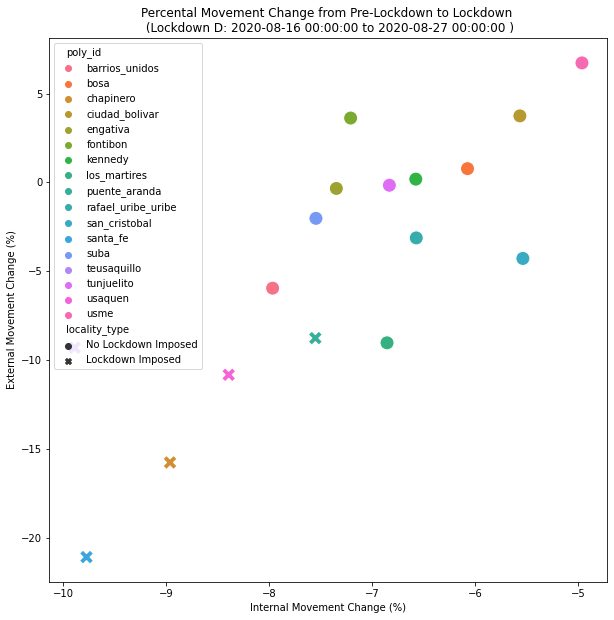

In [25]:
for lock in lockdowns:

    duration = (pd.to_datetime(lock['end_date']) - pd.to_datetime(lock['start_date'])).days

    
    lockdown_start = pd.to_datetime(lock['start_date'])
    lockdown_end = pd.to_datetime(lock['end_date'])

    # Filter by date
    df_temp = df_movement.copy()
    
    df_temp['moment'] = None
    
    # Assigns moments
    df_temp.loc[(df_movement.date_time <= pre_lockdown_end) 
                & (df_movement.date_time >= pre_lockdown_start),'moment'] = "Pre-Lockdown"

    df_temp.loc[(df_movement.date_time <= lockdown_end) 
                & (df_movement.date_time >= lockdown_start),'moment'] = "Lockdown"

    # Filters
    df_temp = df_temp[~df_temp.moment.isna()].copy()

    # Then by week
    df_temp = df_temp[["poly_id","moment","movement_type","movement"]].groupby(["poly_id","moment","movement_type"]).mean().reset_index()
    
    df_temp = df_temp.pivot_table(index = ['poly_id'], columns=["moment","movement_type"], values = ['movement']).reset_index()
    #df_temp.columns = ["poly_id",'moment',"external_movement","internal_movement"]
    
    df_temp['external_change'] = 100*(df_temp.movement.Lockdown.External -  df_temp.movement["Pre-Lockdown"].External)/df_temp.movement["Pre-Lockdown"].External
    df_temp['internal_change'] = 100*(df_temp.movement.Lockdown.Internal -  df_temp.movement["Pre-Lockdown"].Internal)/df_temp.movement["Pre-Lockdown"].Internal
    df_temp['all_change'] = 100*((df_temp.movement.Lockdown.Internal + df_temp.movement.Lockdown.External) - (df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External))/(df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External)
    df_temp['locality_type'] =  no_lock_lab
    df_temp["locality_type"] = [ int(i) * lock_lab +  (1-int(i)) * no_lock_lab for i in df_temp.poly_id.isin(lock['places']).to_list() ] 
    
    fig=plt.figure(figsize=(10, 10), facecolor='w')
    ax = sns.scatterplot(data = df_temp, 
                    x = "internal_change", 
                    y = "external_change", 
                    hue = "poly_id", 
                    style = "locality_type",
                    s = 200)

    ax.set(xlabel='Internal Movement Change (%)', ylabel='External Movement Change (%)')
    ax.set_title(f"Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown {lock['code']}: {lock['start_date']} to {lock['end_date']} )")
    
    # Saves the dataframe
    df_temp.columns = [ "_".join(col).lower().replace("__","") for col in df_temp.columns.values ]
    df_temp.to_csv( os.path.join(results_dir, f'data/movement_clean/internal_external_lockdown_{lock["code"]}.csv') )


In [26]:
lock = lockdowns[0]

duration = (pd.to_datetime(lock['end_date']) - pd.to_datetime(lock['start_date'])).days


lockdown_start = pd.to_datetime(lock['start_date'])
lockdown_end = pd.to_datetime(lock['end_date'])

# Filter by date
df_temp = df_movement.copy()

df_temp['moment'] = None

# Assigns moments
df_temp.loc[(df_movement.date_time <= pre_lockdown_end) 
            & (df_movement.date_time >= pre_lockdown_start),'moment'] = "Pre-Lockdown"

df_temp.loc[(df_movement.date_time <= lockdown_end) 
            & (df_movement.date_time >= lockdown_start),'moment'] = "Lockdown"

# Filters
df_temp = df_temp[~df_temp.moment.isna()].copy()


# Then by week
df_temp = df_temp[["poly_id","moment","movement_type","movement"]].groupby(["poly_id","moment","movement_type"]).mean().reset_index()
df_temp = df_temp.pivot_table(index = ['poly_id'], columns=["moment","movement_type"], values = ['movement']).reset_index()
#df_temp.columns = ["poly_id",'moment',"external_movement","internal_movement"]

df_temp['external_change'] = 100*(df_temp.movement.Lockdown.External -  df_temp.movement["Pre-Lockdown"].External)/df_temp.movement["Pre-Lockdown"].External
df_temp['internal_change'] = 100*(df_temp.movement.Lockdown.Internal -  df_temp.movement["Pre-Lockdown"].Internal)/df_temp.movement["Pre-Lockdown"].Internal
df_temp['all_change'] = 100*((df_temp.movement.Lockdown.Internal + df_temp.movement.Lockdown.External) - (df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External))/(df_temp.movement["Pre-Lockdown"].Internal + df_temp.movement["Pre-Lockdown"].External)
df_temp['locality_type'] =  no_lock_lab
df_temp["locality_type"] = [ int(i) * lock_lab +  (1-int(i)) * no_lock_lab for i in df_temp.poly_id.isin(lock['places']).to_list() ] 


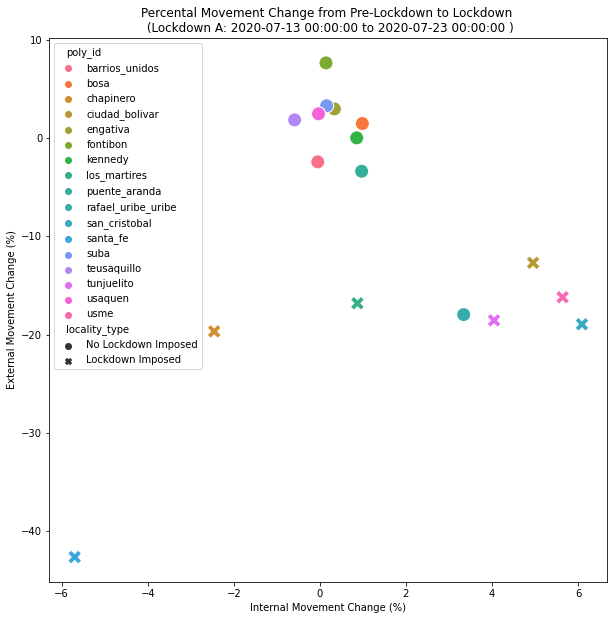

In [27]:
fig=plt.figure(figsize=(10, 10), facecolor='w')
ax = sns.scatterplot(data = df_temp, 
                x = "internal_change", 
                y = "external_change", 
                hue = "poly_id", 
                style = "locality_type",
                s = 200)

ax.set(xlabel='Internal Movement Change (%)', ylabel='External Movement Change (%)')
ax.set_title(f"Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown {lock['code']}: {lock['start_date']} to {lock['end_date']} )")


# Saves the dataframe

df_temp.columns = [ "_".join(col).lower().replace("__","") for col in df_temp.columns.values ]
df_temp.to_csv( os.path.join(results_dir, f'data/movement_clean/internal_external_lockdown_{lock["code"]}.csv') )

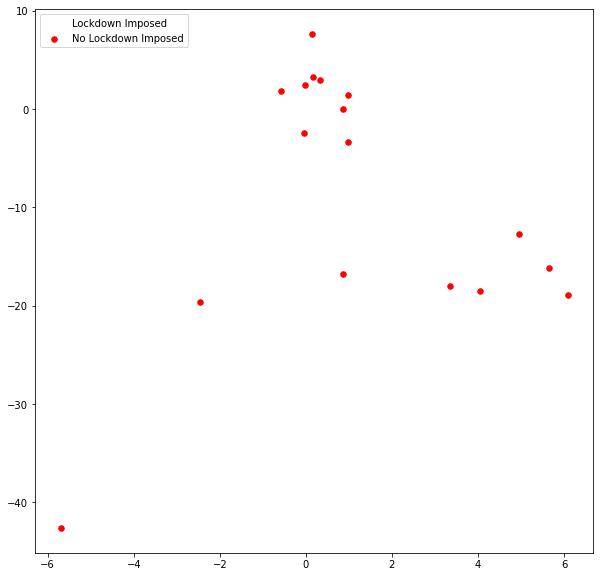

In [9]:
s = 30
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

df_plot_lock    = df_temp[df_temp.locality_type == lock_lab]
df_plot_no_lock = df_temp[df_temp.locality_type == no_lock_lab]

ax1.scatter(df_plot_lock.internal_change,    df_plot_lock.external_change, color = df_plot_lock.poly_id, s=s, marker="s", label= lock_lab)
ax1.scatter(df_plot_no_lock.internal_change, df_plot_no_lock.external_change, s=s, c='r', marker="o", label= no_lock_lab)
plt.legend(loc='upper left');
plt.show()

Text(0.5, 1.0, 'Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown: 2020-07-13 to 2020-07-23 )')

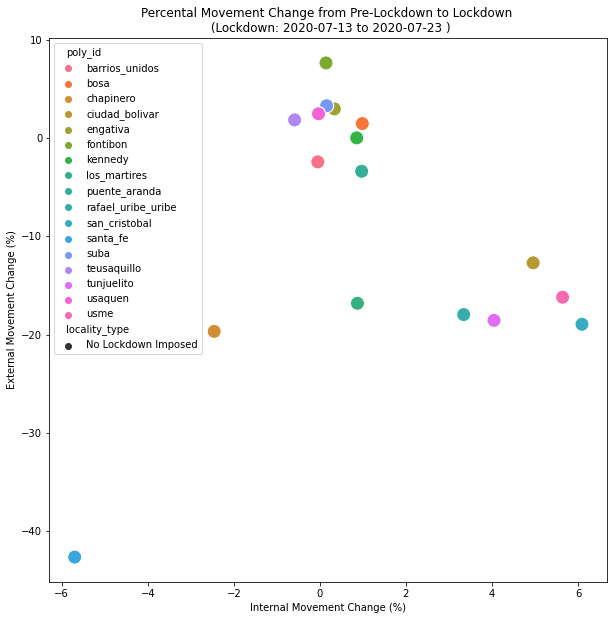

In [12]:
fig=plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = df_temp, 
                x = "internal_change", 
                y = "external_change", 
                hue = "poly_id", 
                style = "locality_type",
                s = 200)

ax.set(xlabel='Internal Movement Change (%)', ylabel='External Movement Change (%)')
ax.set_title(f"Percental Movement Change from Pre-Lockdown to Lockdown \n (Lockdown: {lock['start_date']} to {lock['end_date']} )")